<a href="https://colab.research.google.com/github/leonorand/capsule_network/blob/master/20190918_capsule_data_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras
from keras import activations
from keras import backend as K
from keras.engine.topology import Layer
 
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm)/ (0.5 + s_squared_norm)
    return scale * x
 
 
#define our own softmax function instead of K.softmax
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex/K.sum(ex, axis=axis, keepdims=True)
 
 
#A Capsule Implement with Pure Keras
class Capsule(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, share_weights=True, activation='squash', **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)
 
    def build(self, input_shape):
        super(Capsule, self).build(input_shape)
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1, input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule,
                                            input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)
 
    def call(self, u_vecs):
        if self.share_weights:
            u_hat_vecs = K.conv1d(u_vecs, self.W)
        else:
            u_hat_vecs = K.local_conv1d(u_vecs, self.W, [1], [1])
 
        batch_size = K.shape(u_vecs)[0]
        input_num_capsule = K.shape(u_vecs)[1]
        u_hat_vecs = K.reshape(u_hat_vecs, (batch_size, input_num_capsule,
                                            self.num_capsule, self.dim_capsule))
        u_hat_vecs = K.permute_dimensions(u_hat_vecs, (0, 2, 1, 3))
        #final u_hat_vecs.shape = [None, num_capsule, input_num_capsule, dim_capsule]
 
        b = K.zeros_like(u_hat_vecs[:,:,:,0]) #shape = [None, num_capsule, input_num_capsule]
        for i in range(self.routings):
            c = softmax(b, 1)
            o = K.batch_dot(c, u_hat_vecs, [2, 2])
            if K.backend() == 'theano':
                o = K.sum(o, axis=1)
            if i < self.routings - 1:
                o = K.l2_normalize(o, -1)
                b = K.batch_dot(o, u_hat_vecs, [2, 3])
                if K.backend() == 'theano':
                    b = K.sum(b, axis=1)
 
        return self.activation(o)
 
    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, None, None, 1)     0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, None, None, 64)    640       
_________________________________________________________________
conv2d_58 (Conv2D)           (None, None, None, 64)    36928     
_________________________________________________________________
average_pooling2d_15 (Averag (None, None, None, 64)    0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, None, None, 128)   73856     
_________________________________________________________________
conv2d_60 (Conv2D)           (None, None, None, 128)   147584    
_________________________________________________________________
reshape_15 (Reshape)         (None, None, 128)         0         
__________

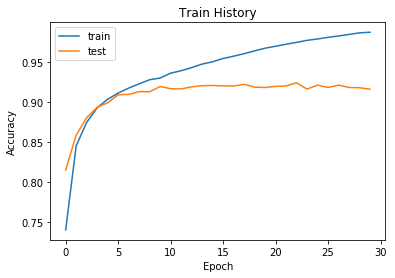

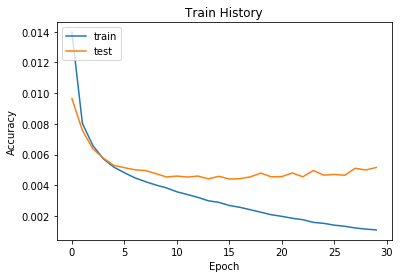

[9 0 0 3 0 2 7 2 5 5]


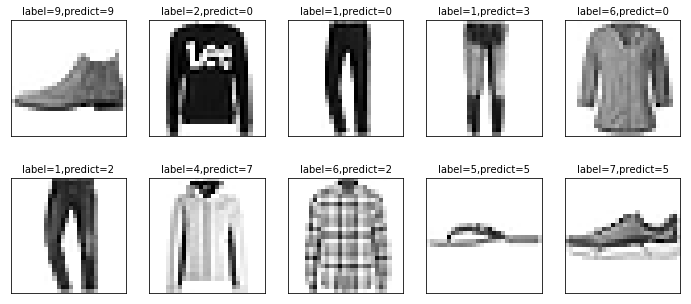

In [25]:
#! -*- coding: utf-8 -*-
 
#from Capsule_Keras import *
from keras import utils
from keras.models import Model
from keras.layers import *
from keras import backend as K
from keras.datasets import fashion_mnist
 
#准备训练数据
batch_size = 128
num_classes = 10
img_rows, img_cols = 28, 28

#加载数据集
(x_train, y_train), (x_Test, y_Test) = fashion_mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_Test.reshape(x_Test.shape[0], img_rows, img_cols, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255




#换one hot格式
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_Test, num_classes)
 
 
#准备自定义的测试样本
#对测试集重新排序并拼接到原来测试集，就构成了新的测试集，每张图片有两个不同数字
idx = range(len(x_test))
#打乱顺序
np.random.shuffle(idx)
#传入的数组必须具有相同的形状，这里的相同的形状可以满足在拼接方向axis轴上数组间的形状一致即可
X_test = np.concatenate([x_test, x_test[idx]], 1)
#np.vstack:按垂直方向（行顺序）堆叠数组构成一个新的数组
Y_test = np.vstack([y_test.argmax(1), y_test[idx].argmax(1)]).T
X_test = X_test[Y_test[:,0] != Y_test[:,1]] #确保两个数字不一样
Y_test = Y_test[Y_test[:,0] != Y_test[:,1]]
Y_test.sort(axis=1) #排一下序，因为只比较集合，不比较顺序
 

 
#搭建CNN+Capsule分类模型
## 一个常规的 Conv2D 模型
input_image = Input(shape=(None,None,1))
cnn = Conv2D(64, (3, 3), activation='relu')(input_image)
cnn = Conv2D(64, (3, 3), activation='relu')(cnn)
cnn = AveragePooling2D((2,2))(cnn)
cnn = Conv2D(128, (3, 3), activation='relu')(cnn)
cnn = Conv2D(128, (3, 3), activation='relu')(cnn)
 
cnn = Reshape((-1, 128))(cnn)
capsule = Capsule(10, 16, 3, True)(cnn)
output = Lambda(lambda x: K.sqrt(K.sum(K.square(x), 2)), output_shape=(10,))(capsule)
 
model = Model(inputs=input_image, outputs=output)
model.compile(loss=lambda y_true,y_pred: y_true*K.relu(0.9-y_pred)**2 + 0.25*(1-y_true)*K.relu(y_pred-0.1)**2,
              optimizer='adam',
              metrics=['accuracy'])
 
model.summary()
 
train_history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=30,
          verbose=1,
          validation_data=(x_test, y_test))
 
Y_pred = model.predict(X_test) #用模型进行预测
greater = np.sort(Y_pred, axis=1)[:,-2] > 0.5 #判断预测结果是否大于0.5
Y_pred = Y_pred.argsort()[:,-2:] #取最高分数的两个类别
Y_pred.sort(axis=1) #排序，因为只比较集合
 
acc = 1.*(np.prod(Y_pred == Y_test, axis=1)).sum()/len(X_test)
print ('CNN+Capsule，不考虑置信度的准确率为：%s'%acc)
acc = 1.*(np.prod(Y_pred == Y_test, axis=1)*greater).sum()/len(X_test)
print ('CNN+Capsule，考虑置信度的准确率为：%s'%acc)

###测试集输出结果可视化

import tensorflow as tf
from __future__ import print_function
import matplotlib.pyplot as plt
def show_train_history(train_acc,test_acc):
    plt.plot(train_history.history[train_acc])
    plt.plot(train_history.history[test_acc])
    plt.title('Train History')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('1.png')
    plt.show()
#准确率预测
show_train_history('acc','val_acc')
#损失函数预测
show_train_history('loss','val_loss')

#结果预测
prediction = model.predict(x_train)
prediction=np.argmax(prediction,axis=1)

#prediction=model.predict_classes(x_train)
print(prediction[:10])
prediction[:10]

#结果可视化
import matplotlib.pyplot as plt
def plot_images_labels_prediction(images,labels,prediction,idx,num=10):
    fig = plt.gcf()
    fig.set_size_inches(12, 14)
    if num>25: num=25 
    for i in range(0, num):
        ax=plt.subplot(5,5, 1+i)
        ax.imshow(images[idx], cmap='binary')

        ax.set_title("label=" +str(labels[idx])+
                     ",predict="+str(prediction[idx])
                     ,fontsize=10) 
        
        ax.set_xticks([]);ax.set_yticks([])        
        idx+=1 
    plt.show()

plot_images_labels_prediction(x_Test,y_Test,prediction,idx=0)



